# PDHG Non-cartesian
This notebook applies the PDHG algorithm on a non-cartesian mask based on the paper "Learning the Sampling Pattern for MRI" published in June 2019. More details on the functions (and especially on the proximal operators) can be found there.

## Imports

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN ,FFT, gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold,Ridge

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from PIL import Image
from modopt.math.matrix import PowerMethod

## Inputs

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = np.asarray(u0)

# Obtain MRI non-cartesian mask
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
radialmask = pysap.Image(data=convert_locations_to_mask(radial_kspace_loc, u0.shape))
radial_fourier = NonCartesianFFT(samples=radial_kspace_loc, shape=u0.shape,implementation='cpu')

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


### Base mask

In [4]:
n = 512
kspace_loc = np.empty((n**2,2))
for i in range(n):
    for j in range(n):
        kspace_loc[n*i+j]=[i/n-0.5,j/n-0.5]

In [5]:
m = convert_locations_to_mask(kspace_loc,u0.shape)

In [6]:
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

In [7]:
# Verification que ifft(fft(im))~im
y = fourier_op.op(u0_mat)
uk = fourier_op.adj_op(y)
pysap.Image(data = np.abs(uk)).show()

### Compute S(p) for given mask

In [8]:
p = np.zeros((n*n,))
for i in range(len(radial_kspace_loc)):
    x = int((n-1)*(radial_kspace_loc[i][0]+0.5))
    y = int((n-1)*(radial_kspace_loc[i][1]+0.5))
    p[n*x+y] = 1

In [9]:
new_loc = []
for i in range(512):
    for j in range(512):
        if p[n*i+j] == 1:
            new_loc.append(kspace_loc[n*i+j])
pysap.Image(data = convert_locations_to_mask(np.array(new_loc),u0.shape)).show()

In [10]:
uk = fourier_op.adj_op(p*fourier_op.op(u0_mat))
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.7611498634499178


### Data
Observations: $y=S\mathcal{F}Ru+\epsilon$.

In [11]:
# Adding noise
(n1,n2) = u0.shape
s = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = fourier_op.op(u0.data)
y += np.asarray([np.random.normal(0,s)+np.random.normal(0,s)*1j for i in range(len(y))])
u0_mat = np.asarray(u0)

pn1 = 1e-7

## Linear operators: wavelet transform and gradient

In [255]:
linear_op = WaveletN(wavelet_name="haar",nb_scale=7,padding_mode = "periodization")

In [13]:
def GradientIm(image):    
    horiz_difference = image[1:, :] - image[0:-1,:]
    gradient_y = (np.c_[horiz_difference.T,np.zeros(horiz_difference.shape[1])]).T
        
    vert_difference = image[:,1:] - image[:,0:-1]
    gradient_x = np.c_[vert_difference,np.zeros(vert_difference.shape[0])]
                       
    return  np.array([gradient_x, gradient_y])

def DivergenceIm(m):
    matrix_1 = m[0]
    matrix_2 = m[1]
#     a1 = matrix_1[:,:-1]
#     m1_1 = (np.c_[a1,np.zeros(matrix_1.shape[1])])
#     m1_2 = (np.c_[np.zeros(matrix_1.shape[1]),a1])
#     temp_1 = m1_2-m1_1
    
    horiz_difference = matrix_2[:,1:-1] - matrix_2[:,0:-2]
    temp_1 = np.c_[matrix_2[:,0],horiz_difference,-matrix_2[:,-1]]
    
#     a2 = matrix_2[:-1,:].T
#     m2_1 = (np.c_[a2,np.zeros(matrix_2.shape[0])]).T
#     m2_2 = (np.c_[np.zeros(matrix_2.shape[0]),a2]).T
#     temp_2 = m2_2-m2_1
    
    vert_difference = matrix_1[1:-1, :] - matrix_1[0:-2,:]
    temp_2 = np.c_[matrix_1[0,:],vert_difference.T,-matrix_1[-1,:]]
    temp_2 = temp_2.T
    return temp_1 + temp_2

In [14]:
uk = fourier_op.adj_op(p*y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.6789563671972499


# Definition of functions to compute energy
Since S is a nxn diagonal matrix, we won't store it in memory and do all the computations directly with p

In [19]:
#constants
zeta = 1e10
epsilon = 1e-3
gamma = 1e-10
pn1 = 1e-5

In [20]:
# functions B and G in the paper
def b(u):
    return np.sum([np.sum([max(0,-z**3)for z in u[i]]) for i in range(len(u))])*zeta
def g(u):return np.real(b(u)+epsilon*np.linalg.norm(u)**2/2)

In [29]:
# functions J and F2 in the paper
# We also compute rho and its first derivative since we will need it later
def rho(x):
    m = np.absolute(x)
    return -m*m*m/3/gamma/gamma+m*m/gamma if m<gamma else m-gamma/3

def drho(x):
    if x<-gamma:return -1
    elif x<0:return x**2/gamma**2+2*x/gamma
    elif x<gamma:return -x**2/gamma**2+2*x/gamma
    else:return 1
    

def J(u):
    global pn1
    if len(u.shape) == 2:
        return pn1*np.sum([np.sum([rho(x) for x in y])for y in u])
    else:
        return pn1*np.sum([rho(x) for x in u])
def f2(w):
    #linear_op
    if len(w.shape) == 1:
        return J(np.abs(w))
    else:
        (l,n,p) = w.shape
        v = 1.*np.zeros((n,p))
        for i in range(n):
            for m in range(p):
                v[i][m] = np.linalg.norm([w[k][i][j] for k in range(l)])
        return J(v)

In [30]:
#function F1 in the paper
def R(u):
    return np.asarray([[np.real(u[i][j]) for j in range(len(u[0]))]for i in range(len(u))])
def Rstar(u):
    return np.array([[u[i][j]+0j for j in range(len(u[0]))]for i in range(len(u))])
def f1(v):
    return 0.5*np.linalg.norm(p*fourier_op.op(v)-y)**2

In [171]:
def energy_wavelet(u):
    return(f1(Rstar(u))+f2(np.array(linear_op.op(u)))+g(u))
def energy_grad(u):
    return(f1(Rstar(u))+f2(np.array(GradientIm(u)))+g(u))

In [172]:
pn1 = 1e-5
print(energy_wavelet(np.zeros(u0_mat.shape)))
print(energy_wavelet(u0_mat))
print(energy_wavelet(2*u0_mat))

2.1676779698962723e-06
1.43368538327019e-06
4.384424771828984e-06


# Proximal operators
The objective is to find the point minimizing $f_u(x) = F(x)+1/2||x-u||^2$ for a given u and for $F=\tau F1,\tau F2,\tau G$ where $\tau$ is a given constant.
## Proximal operator of F2
We want to minimize $f_u(x) = \tau\alpha (p)J(|x|)+\frac{1}{2}||x-u||^2$. As explained in the paper, given the definition of J, we can compute the solution component by component, but the paper expresses $x_i$ in terms of $u_i$ with a constant C that we need to compute. We have in 1D $f_u'(x) = \tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$. Since $\rho '(x)$ depends on if $|x|<\gamma$ or not, we need to separate these two cases:
### |x|>$\gamma$
In this case, $\rho '(|x|)=1$, so we simply have $(1+\frac{\tau\alpha(p)}{|x|})x=u\Rightarrow x=(|u|-\tau\alpha(p))\frac{u}{|u|}$. Since we supposed $|x|<\gamma$ beforehand, this will be true when $|u|>\tau\alpha(p)+\gamma$.
### |x|$\leq\gamma$
From what we just saw, this is equivalent to $|u|\leq\tau\alpha(p)+\gamma$. This case is a bit more complicated, since now $\rho '(|x|)=-\frac{|x|^2}{\gamma^2}+2\frac{|x|}{\gamma}$ and taking the norm on both sides of $\tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$ gives us:
$$-\frac{\tau\alpha(p)}{\gamma^2}|x|^2+(1+\frac{2\tau\alpha(p)}{\gamma})|x|-|u|=0\\
\Rightarrow |x| = \gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1\pm\sqrt{\Delta})\\
with\ \Delta=1+\frac{4\tau\alpha(p)}{\gamma^2}(\gamma+\tau\alpha(p)-|u|)$$
But since we want $|x|<\gamma$, the only acceptable solution is $x=\left(\gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1-\sqrt{\Delta})\right)\frac{u}{|u|}$. Since $|u|\leq\tau\alpha(p)+\gamma$, we see that $\Delta>1$, so the condition $|x|\leq\gamma$ is verified.

## Proximal operator of F1
The expression given in the paper is:
$$prox_{\tau F1}(u) = \mathcal{F}(I+\tau S(p)^2)^{-1}(\mathcal{F}u+\tau S(p)^2y)$$
with y the data.\\
I find a different value when I recompute it: we want to minimize $f_u(x) = \frac{1}{2}\tau||S(p)(\mathcal{F}x-y)||+\frac{1}{2}||x-u||^2$. When we differentiate, we get:
$$f_u(x+h) = f_u(x)+\tau <S(p)\mathcal{F}h,S(p)(\mathcal{F}x-y)> + <h,(x-u)>+o(||h||)$$
Since S(p) is diagonal, we have:
$$f_u(x+h)-f_u(x) = <\mathcal{F}h,\tau S(p)^2(\mathcal{F}x-y)>+<h,x-u>+o(||h||)\\
\Rightarrow \nabla f_u(x) = \mathcal{F}^{-1}\left[\tau S(p)^2(\mathcal{F}x-y)\right]+x-u$$


## Proximal dual operators
We use the Moreau identity to compute the proximal dual operators:
$$prox_{\gamma\phi ^*}(x) = x-\gamma prox_{\phi/\gamma}(\frac{x}{\gamma})$$

In [35]:
#Prox_tauG
def prox_B(u,c):
    global zeta
    return np.asarray([[x/(0.5+np.sqrt(0.25-3*zeta*c*min(0,x)))for x in u[i]]for i in range(len(u))])
def prox_G(u,c):
    global epsilon
    return prox_B(u/(1+c*epsilon),1/(1+c*epsilon))

def prox_G2(u,c):
    pG = np.zeros(u0_mat.shape)
    for i in range(len(u)):
        for j in range(len(u[0])):
            pG[i][j] = u[i][j]/(1+epsilon*c) if u[i][j]>0 else u[i][j]/(0.5+np.sqrt(0.25-3*zeta*c*u[i][j]/(1+epsilon*c)**2))
    return pG

In [36]:
c=5
a = 0.01*gamma*np.random.rand(512,512)
y1 = prox_G(a,c)
y2 = y1+np.asarray([[np.random.normal(0,1e-10)for i in range(n2)]for j in range(n1)])
y3 = prox_G2(a,c)


r1 = c*g(y1)+0.5*np.linalg.norm(a-y1)**2
r2 = c*g(y2)+0.5*np.linalg.norm(a-y2)**2
r3 = c*g(y3)+0.5*np.linalg.norm(a-y3)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):"
                  ,np.abs(r1)/np.abs(r2))

Distance between the two points: 5.125678596677608e-08
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 1.854003117454862e-08


In [22]:
#From Sherry's Matlab code
# https://github.com/fsherry/bilevel-MRI-examples/blob/master/lowerlevel_numeric/proximal_operators/proxF2star.m
def prox_J(z,gamma,c):
    (l,n,p) = z.shape
    out = (1+1j)*np.zeros((l,n,p))
    for i in range(n):
        for m in range(p):
            mod = np.linalg.norm([z[k][i][m] for k in range(l)])
            for k in range(l):
                if mod>gamma+c:
                    out[k][i][m] = z[k][i][m]*(1-c/mod)
                else:
                    out[k][i][m] = gamma*z[k][i][m]/(c+0.5*gamma+np.sqrt((c+0.5*gamma)**2-c*mod))
    return out

def prox_F2_test(z,c):
    return z-c*prox_J(z/c,gamma,pn1/c)

In [40]:
def prox_F2(u,c):
    if len(u.shape)==1:
        v = []
        for x in u:
            mod = np.abs(x)
            if mod>c*pn1+gamma:
                v.append(x*(mod-c*pn1)/mod)
            else:
                delta = 1+4*c*pn1/gamma/gamma*(gamma+c*pn1-mod)
                const = gamma+gamma*gamma/(2*c*pn1)*(1-np.sqrt(delta))
                v.append(0 if mod==0 else const*x/mod)
        return np.array(v)
    else:
        (l,n,p) = u.shape
        out = (1+1j)*np.zeros((l,n,p))
        for i in range(n):
            for j in range(p):
                mod = np.linalg.norm([u[k][i][j] for k in range(l)])
                if mod>c*pn1+gamma:
                    for k in range(l):
                        out[k][i][j] = u[k][i][j]*(mod-c*pn1)/mod
                else:
                    delta = 1+4*c*pn1/gamma/gamma*(gamma+c*pn1-mod)
                    const = gamma+gamma*gamma/(2*c*pn1)*(1-np.sqrt(delta))
                    for k in range(l):
                        if mod == 0:
                            out[k][i][j] = 0
                        else:
                            out[k][i][j] = const*u[k][i][j]/mod
        return out

def prox_F2_dual(u,c):
    return u-c*prox_F2(u/c,1/c)

In [42]:
c=2
a = linear_op.op(fourier_op.adj_op(p*y))
y1 = prox_F2(a,c)
y2 = y1+1e-6*np.random.rand(512*512)

r1 = c*f2(y1)+0.5*np.linalg.norm(a-y1)**2
r2 = c*f2(y2)+0.5*np.linalg.norm(a-y2)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):",r1/r2)

Distance between the two points: 0.00029572985861025966
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 0.2226650120259279


In [43]:
#prox_tauF1
def prox_F1(u,c):
    im=(fourier_op.op(u)+c*p*p*y)/(np.ones(y.shape)+c*p*p)
    return fourier_op.adj_op(im)

def prox_F1_dual2(u,c):
    return u-c*prox_F1(u/c,1/c)

def prox_F1_dual(u,c):
    global p
    inner = (fourier_op.op(u)+p*p*y)/(c*np.ones(y.shape)+p*p)
    return u-c*fourier_op.adj_op(inner)

# Test with only one regulariser
We only use F1 and G.

In [150]:
#constants
zeta = 1e15
epsilon = 1e4

In [151]:
L=1
mu = 2*np.sqrt(epsilon/(1+L*L))
tau = mu/2/epsilon
sigma = mu/2
theta = 1/(1+mu)

tol = 1e-4

In [96]:
print(f1(u0_mat),g(u0_mat))

3.2689696730111117e-07 0.019073484054388315


In [152]:
def step_test(uk,vk,uk_bar):
    global theta,tau,sigma
    vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma)
    uk1 = prox_G2(uk-tau*np.real(vk1),tau)    
    uk_bar1 = uk1+theta*(uk1-uk)

    norm = np.linalg.norm(uk1-uk)/np.linalg.norm(uk)
    norm += (np.linalg.norm(vk1-vk))/(np.linalg.norm(vk))
    return uk1,vk1,uk_bar1,norm

In [153]:
#initialisation
n_iter = 0
uk = np.real(fourier_op.adj_op(p*y))
vk = np.copy(uk)
uk_bar = np.copy(uk)
norm = 2*tol

energy_f1 = [f1(uk)]
energy_g = [g(uk)]
norms = []
ssims = [ssim(uk,u0_mat)]
#image_rec0.show()
#print(ssim(uk,u0_mat))

In [154]:
print("Base ssim:",ssim(uk,u0_mat))
while norm>tol and n_iter<100:
    uk,vk,uk_bar,norm = step_test(uk,vk,uk_bar)
    n_iter += 1
    
    energy_f1.append(f1(uk))
    energy_g.append(g(uk))
    norms.append(norm)
    ssims.append(ssim(uk,u0_mat))
    
    print(n_iter," iterations:\nCost:",energy_f1[-1]+energy_g[-1],"\nssim:",ssims[-1],"\nNorm:",norm,"\n")
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

Base ssim: 0.7492049976313807
1  iterations:
Cost: 2.4686828734092863e-05 
ssim: 0.7257510258240502 
Norm: 1.9827369389824039 

2  iterations:
Cost: 2.2546971579439483e-06 
ssim: 0.4993108446886969 
Norm: 11.916473581217222 

3  iterations:
Cost: 2.1838165996516855e-06 
ssim: 0.4585569560626431 
Norm: 0.6409253959671363 

4  iterations:
Cost: 2.17977389843209e-06 
ssim: 0.46967325505027574 
Norm: 0.06778252594194804 

5  iterations:
Cost: 2.1792846997515847e-06 
ssim: 0.47269430531793444 
Norm: 0.013859276540296442 

6  iterations:
Cost: 2.1792114542572804e-06 
ssim: 0.47342192123782717 
Norm: 0.004044341630052534 

7  iterations:
Cost: 2.1791987373877236e-06 
ssim: 0.47361900614297064 
Norm: 0.0016033893574182766 

8  iterations:
Cost: 2.1791961553390643e-06 
ssim: 0.47368012342441945 
Norm: 0.0008036059871946977 

9  iterations:
Cost: 2.1791955337431457e-06 
ssim: 0.47370261323584245 
Norm: 0.00047035301788920906 

10  iterations:
Cost: 2.17919535580501e-06 
ssim: 0.4737116361063388 

In [148]:
#Final image
image_rec = pysap.Image(data=np.real(uk))
print(ssim(uk,u0_mat))
image_rec.show()

0.13676119910646764


In [131]:
g(uk)

8.346192862770294e-06

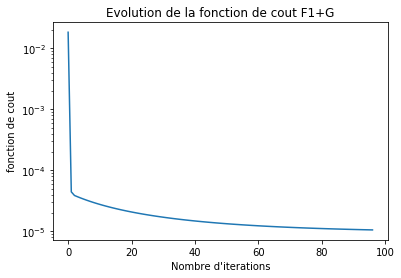

In [132]:
plt.plot([energy_f1[i]+energy_g[i] for i in range(len(energy_g))])
plt.xlabel("Nombre d'iterations")
plt.ylabel("fonction de cout")
plt.title("Evolution de la fonction de cout F1+G")
plt.yscale("log")
#plt.savefig("Cout_faible_pen.png")

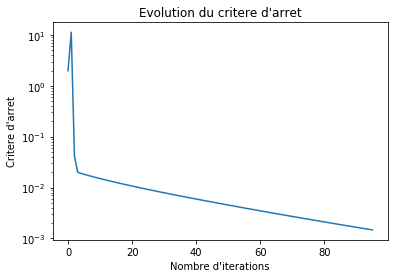

In [133]:
plt.plot(norms)
plt.xlabel("Nombre d'iterations")
plt.ylabel("Critere d'arret")
plt.title("Evolution du critere d'arret")
plt.yscale("log")
#plt.savefig("norm_faible_pen.png")

Text(0.5, 1.0, "Evolution de la ssim avec l'image initiale")

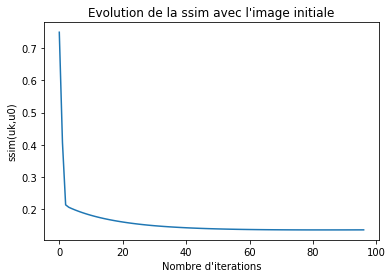

In [134]:
plt.plot(ssims)
plt.xlabel("Nombre d'iterations")
plt.ylabel("ssim(uk,u0)")
plt.title("Evolution de la ssim avec l'image initiale")
#plt.savefig("ssim_forte_pen.png")

### Tests
- $\zeta=10^{15}$ and $\epsilon=10^4$: in this case, $G(u_0)/F_1(u_0)\approx10^5$. Convergence in 14 iterations, with a final image with an amplitude of $\approx 10^{-9}$.
- $\zeta=10^{10}$ and $\epsilon=10^4$: Extremely slow convergence, final image after 100 iterations negative.
- $\zeta=10^{10}$ and $\epsilon=10^{-8}$: increase of $F_1$ at the beginning, $G$ decreases quickly and stabilizes. Sudden decrease of $\frac{||u_{k+1}-u_k||}{||u_k||}+\frac{||v_{k+1}-v_k||}{||v_k||}$ after $\approx20$ iterations, but no further convergence after that (stuck at $\approx 2.10^{-4}$). Final image **negative**. The final result in $v_k$ is actually closer to the real image than the final $u_k$.
- $\zeta=10^{15}$ and $\epsilon=10^{-8}$: Should penalize more the negative values. Same result as before: sudden convergence after 20 iterations, final image less negative scale of about $10^{-11}$ compared to $10^{-8}$ with previous parameters).

## With F2 only

In [346]:
#constants
#convergence quand pn1 tres faible (1e-10)
pn1 = 1e-5

L=1
eta = max(1,pn1*6/gamma)
mu = 2*np.sqrt(1/(1+L*L)/eta)
tau = mu/2
sigma = mu*eta/2
theta = 1/(1+mu)

maxit = 20
tol = 1e-4

In [347]:
print(f1(u0_mat),f2(linear_op.op(u0_mat)))

3.2689696730111117e-07 9.969425708082329e-07


In [348]:
def step_test2(uk,vk,wk,uk_bar):
    vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma)
    wk1 = prox_F2_dual(wk+sigma*linear_op.op(uk_bar),sigma)
    uk1 = uk-tau*R(vk1)-tau*linear_op.adj_op(wk1)
    uk_bar1 = uk1+theta*(uk1-uk)

    norm = (np.linalg.norm(vk1-vk)+np.linalg.norm(wk1-wk))/(np.linalg.norm(vk)+np.linalg.norm(wk))
    return uk1,vk1,wk1,uk_bar1,norm

In [349]:
#initialisation
n_iter = 0
uk = np.real(fourier_op.adj_op(p*y))
image_rec0 = pysap.Image(data=np.abs(uk))

vk = np.copy(uk)
wk = linear_op.op(uk)
uk_bar = np.copy(uk)
norm = 2*tol

energies = [energy(uk)]
norms = []
ssims = [ssim(uk,u0_mat)]
#image_rec0.show()
#print(ssim(uk,u0_mat))

In [350]:
while n_iter<100 and norm>tol:
    uk,vk,wk,uk_bar,norm = step_test2(uk,vk,wk,uk_bar)
    n_iter += 1
    norms.append(norm)
    energies.append(f1(uk)+f2(np.array(GradientIm(uk))))
    ssims.append(ssim(uk,u0_mat))
    print(n_iter," iterations:\nCost:",energies[-1],"\nssim:",ssims[-1],"\nNorm:",norm,"\n")
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

1  iterations:
Cost: 1.1088818909803405e-06 
ssim: 0.751768852078799 
Norm: 1.8518454921297218 

2  iterations:
Cost: 1.090681712066197e-06 
ssim: 0.7542696842265452 
Norm: 0.0033307554617508337 

3  iterations:
Cost: 1.0725584831890313e-06 
ssim: 0.7566837397500373 
Norm: 0.07185985302069106 

4  iterations:
Cost: 1.0545805908011807e-06 
ssim: 0.7589806121513863 
Norm: 0.10223000781713427 

5  iterations:
Cost: 1.0367252229066488e-06 
ssim: 0.7611644803909741 
Norm: 0.10560787479530241 

6  iterations:
Cost: 1.0191816287196224e-06 
ssim: 0.7632608815658702 
Norm: 0.10407000841594063 

7  iterations:
Cost: 1.0020149644150791e-06 
ssim: 0.7653003531636436 
Norm: 0.10642244868303874 

8  iterations:
Cost: 9.85076315826252e-07 
ssim: 0.7672830449923533 
Norm: 0.10933325590101174 

9  iterations:
Cost: 9.683386231594458e-07 
ssim: 0.7692270356795313 
Norm: 0.10996527219241291 

10  iterations:
Cost: 9.520087419677528e-07 
ssim: 0.7710964071477949 
Norm: 0.11051557797653391 

11  iterations

KeyboardInterrupt: 

In [351]:
#Final image
image_rec = pysap.Image(data=np.real(uk))
print(ssim(uk,u0_mat))
image_rec.show()

0.7938358837649736


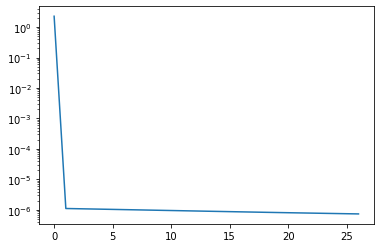

In [352]:
plt.plot(energies)
plt.yscale("log")

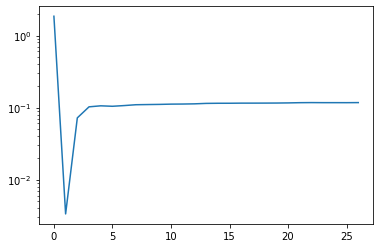

In [353]:
plt.plot(norms)
plt.yscale("log")

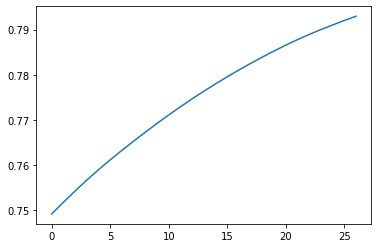

In [354]:
plt.plot(ssims)

# Implementation of the PDHG algorithm

In [314]:
#constants
zeta = 1e15
pn1 = 1e-6
epsilon = 1e-8

In [315]:
L=1
#eta = max(np.amax(p)**2,pn1*6/gamma) for gradient
eta = max(np.amax(p)**2,5*pn1/2/gamma)
mu = 2*np.sqrt(epsilon/(1+L*L)/eta)
tau = mu/2/epsilon
sigma = mu*eta/2
theta = 1/(1+mu)

tol = 1e-4

In [305]:
print(f1(u0_mat),f2(linear_op.op(u0_mat)),g(u0_mat))

3.2689696730111117e-07 9.969425708082327e-08 1.9073484054388314e-11


In [316]:
def step(uk,vk,wk,uk_bar):
    vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma)
    wk1 = prox_F2_dual(wk+sigma*linear_op.op(uk_bar),sigma)
    uk1 = prox_G(uk-tau*np.real(vk1)-tau*linear_op.adj_op(wk1),tau)
    uk_bar1 = uk1+theta*(uk1-uk)

    norm = np.linalg.norm(uk1-uk)/np.linalg.norm(uk)
    norm += (np.linalg.norm(vk1-vk)+np.linalg.norm(wk1-wk))/(np.linalg.norm(vk)+np.linalg.norm(wk))
    return uk1,vk1,wk1,uk_bar1,norm

In [317]:
#initialisation
n_iter = 0
uk = np.real(fourier_op.adj_op(p*y))
image_rec0 = pysap.Image(data=np.abs(uk))

energy_f1 = [f1(uk)]
energy_f2 = [f2(linear_op.op(uk))]
energy_g = [g(uk)]
norms = []
ssims = [ssim(uk,u0_mat)]
#image_rec0.show()
#print(ssim(uk,u0_mat))

In [318]:
vk = np.copy(uk)
wk = linear_op.op(uk)
uk_bar = np.copy(uk)
norm = 2*tol

In [335]:
while n_iter<200 and norm>tol:
    uk,vk,wk,uk_bar,norm = step(uk,vk,wk,uk_bar)
    n_iter += 1
    norms.append(norm)
    energy_f1.append(f1(uk))
    energy_f2.append(f2(linear_op.op(uk)))
    energy_g.append(g(uk))
    ssims.append(ssim(uk,u0_mat))
    print(n_iter," iterations:\nCost:",energy_f1[-1]+energy_f2[-1]+energy_g[-1]
          ,"\nssim:",ssims[-1],"\nNorm:",norm,"\n")
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

134  iterations:
Cost: 3.790919305802022e-07 
ssim: 0.8702891797077648 
Norm: 0.009089445792073917 

135  iterations:
Cost: 3.7890577246075894e-07 
ssim: 0.8691067522190684 
Norm: 0.009086920489671024 

136  iterations:
Cost: 3.7871768485430865e-07 
ssim: 0.8680044971422958 
Norm: 0.009048492199443012 

137  iterations:
Cost: 3.785564854974923e-07 
ssim: 0.8670711498903301 
Norm: 0.008871014014002938 

138  iterations:
Cost: 3.7840961089868944e-07 
ssim: 0.8665040986484049 
Norm: 0.008693586599493028 

139  iterations:
Cost: 3.782516380715558e-07 
ssim: 0.8662576377138855 
Norm: 0.00857493097775311 

140  iterations:
Cost: 3.7810387151066133e-07 
ssim: 0.8662568539294029 
Norm: 0.008432310334719108 

141  iterations:
Cost: 3.779638354735152e-07 
ssim: 0.8664414831808841 
Norm: 0.008248704600023221 

142  iterations:
Cost: 3.7782234251968606e-07 
ssim: 0.8667858185981495 
Norm: 0.008087395692371765 

143  iterations:
Cost: 3.7768269313150235e-07 
ssim: 0.8672549307041088 
Norm: 0.007938

In [336]:
#Final image
image_rec = pysap.Image(data=np.real(uk))
print(ssim(uk,u0_mat))
image_rec.show()

0.8798028639039058


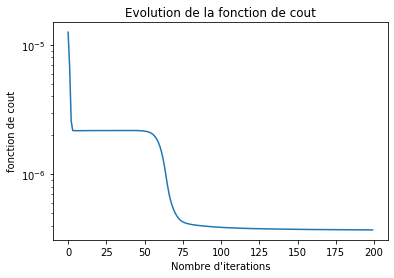

In [337]:
plt.plot(np.array(energy_g[1:])+np.array(energy_f1[1:])+np.array(energy_f2[1:]))
plt.yscale("log")
plt.xlabel("Nombre d'iterations")
plt.ylabel("fonction de cout")
plt.title("Evolution de la fonction de cout")
plt.yscale("log")
#plt.savefig("Cout_tot.png")

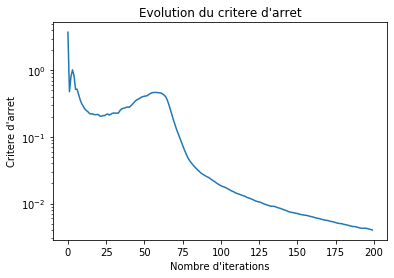

In [338]:
plt.plot(norms)
plt.yscale("log")
plt.xlabel("Nombre d'iterations")
plt.ylabel("Critere d'arret")
plt.title("Evolution du critere d'arret")
plt.yscale("log")
#plt.savefig("norm_tot.png")

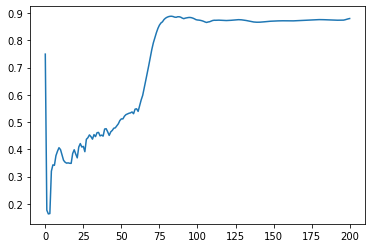

In [339]:
plt.plot(ssims)

### Tests
- $\zeta=10^{15}$, $\epsilon=10^{-1}$, $\alpha(p)(=pn1)=10^{-5}$, haar wavelet 4 scales: In this case, we have $F_1(u_0)\approx F_2(u_0)\approx G(u_0)\approx 10^{-7}$. Slow convergence, but linear as expected. Cost function decreases but extremely slowly ($6,3.10^{-7}$ to $5,6.10^{-7}$ in 100 iterations). $F_2$ and $G$ decrease but $F_1$ increases. Final image has an ssim of 0.84 (after 100 iterations) with an amplitude similar to the original image.

- $\zeta=10^{15}$, $\epsilon=10^{-1}$, $\alpha(p)(=pn1)=10^{-5}$, haar wavelet 7 scales: Same results.

- $\zeta=10^{15}$, $\epsilon=10^{-5}$, $\alpha(p)(=pn1)=10^{-6}$, haar wavelet 7 scales: Converges more quickly (52 iterations for a $tol=10^{-4}$. Good final result (ssim=0.87 with same amplitude as the original image).

- $\zeta=10^{15}$, $\epsilon=10^{-8}$, $\alpha(p)(=pn1)=10^{-6}$, haar wavelet 7 scales:With this value of $\epsilon$, we had strange results with only $F_1$ and $G$. Here, we get a final image after 100 iterations close to the previous one (with $\epsilon=10^{-5}$), which was expected, but the evolution of the cost function and norms are strange: Cost function stable after 5-6 iterations, but drops quickly at $\approx 60$ iterations and norm increases between iterations 30 and 60 before starting to decrease again after this break. When I let it run beyond 100 iterations, the convergence seems to be again slow but linear.

- $\zeta=10^{15}$, $\epsilon=10^{-1}$, $\alpha(p)(=pn1)=10^{0}$, haar wavelet 4 scales: In this case, $F_2\gg F_1,G$. Convergence in 60 iterations. Same strange convergence graph as earlier: sudden drop after $\approx20$ iterations and slow convergence after that. The final image is very smooth inside the brain, but the noise is still there. Final image negative with low amplitude ($10^{-11}$). Decrease of $F_2$ and $G$, increase of $F_1$ again.

***Further tests to do:***
- Use other wavelet transforms: need to know their Lipschitz constant (L in the algorithm). Lipschitz constant of Haar wavelet=1?

- I used the same $\eta$ as in their Matlab code when they are in the case *wavelet_smoothed*, but not sure that this is the correct constant to use (could explain the slow convergence).

- I don't really understand why it doesn't always work with only the $\mathcal{L}^2$ regularizer.